# Module 2: Masked AutoEncoders (MAE) Study Material

## Objectives
- Understand the architecture and training objective of Masked AutoEncoders (MAE).
- Learn how masking and reconstruction facilitate representation learning in vision tasks.
- Explore MAE's applications and its effectiveness in transferring to downstream vision tasks.

## Key Topics
1. **Vision Transformer (ViT) Basics**
2. **MAE Architecture: Encoder, Decoder, and Masking Strategy**
3. **Training Objective: Reconstructing Masked Image Patches**
4. **Applications and Transfer to Downstream Vision Tasks**

---



## 1. Vision Transformer (ViT)
The Vision Transformer (ViT) is a model that applies the transformer architecture, originally designed for natural language processing, to computer vision tasks. Unlike convolutional neural networks (CNNs), ViT treats an image as a sequence of patches.

- **How ViT Works**:
  - An input image is divided into fixed-size patches (e.g., 16x16 pixels).
  - Each patch is flattened into a vector and linearly embedded into a lower-dimensional space.
  - A sequence of patch embeddings is fed into a transformer encoder, which consists of multiple layers of multi-head self-attention and feed-forward networks.
  - Positional embeddings are added to retain spatial information, as transformers do not inherently understand the order of patches.
  - ViT can be used for tasks like image classification by adding a classification token to the sequence.
  
  
   This forms the foundation for MAE's encoder.

  - For classification, a special `[CLS]` token may be appended to the sequence, though MAE often uses average pooling for downstream tasks.

<img src="https://i.postimg.cc/sXM7KL97/Screenshot-2025-07-15-094812.png">

- **Why ViT for MAE?**:
  - Unlike convolutional networks, ViT naturally handles sequences, making it easier to integrate masking (similar to BERT's masked tokens) and positional embeddings.
  - ViT's flexibility allows MAE to process only a subset of patches, reducing computational cost.
  -  Convolutional networks struggle with masking due to their grid-based processing, whereas ViT's sequence-based approach aligns well with MAE's masking strategy.

---



## 2. MAE Architecture: Encoder, Decoder, and Masking Strategy
MAE is a self-supervised learning framework that masks a large portion of an image's patches and trains a model to reconstruct the missing patches. Its architecture is asymmetric, optimizing both efficiency and representation quality.

<img src ="https://i.postimg.cc/LXDr8s0B/Screenshot-2025-07-15-203955.png">

### MAE Architecture
- **Encoder**:
  - Based on ViT, the encoder processes only the unmasked patches (e.g., 25% of the total patches if the masking ratio is 75%).
  - Each patch is embedded via a linear projection with added positional embeddings, then processed through transformer blocks (multi-head self-attention and feed-forward layers).
  - Excluding masked patches reduces computation by up to 3x, enabling scalable training of large models.
- **Decoder**:
  - A lightweight transformer (e.g., fewer layers and narrower dimensions, <10% computation per token compared to the encoder) reconstructs the full image.
  - Takes as input the encoded unmasked patches and mask tokens (learnable vectors indicating missing patches).
  - Positional embeddings are added to all tokens to provide spatial context.
  - Outputs pixel values for each patch, reshaped to form the reconstructed image.
- **Masking Strategy**:
  - Randomly masks a high proportion of patches (e.g., 75%) using a uniform distribution without replacement.
  - High masking ratios create a challenging task, forcing the model to learn holistic image understanding rather than relying on local redundancy .
  - The paper highlights that random sampling outperforms block-wise or grid-wise masking, as it avoids center bias and enables higher masking ratios.

  <img src= "https://i.postimg.cc/Kjrz57Vt/Screenshot-2025-07-15-095611.png">

### How It Works
1. Split an image into patches (e.g., 196 patches for a 224x224 image with 16x16 patches).
2. Randomly mask a large portion (e.g., 75%, or 147 patches), keeping only the unmasked patches (e.g., 49 patches).
3. Encode unmasked patches using the ViT-based encoder.
4. Combine encoded patches with mask tokens and feed them to the decoder.
5. Reconstruct the full image by predicting pixel values for all patches, focusing the loss on masked patches.

<img src="https://i.postimg.cc/26YYJXVq/Screenshot-2025-07-15-215637.png">

### Key Insight from Paper
- The asymmetric design (heavy encoder, lightweight decoder) and high masking ratio reduce pre-training time by 3x or more while improving accuracy (Page 2).
- The decoder's role in vision is to reconstruct low-level pixel data, unlike NLP where decoders predict semantic tokens, necessitating a more complex decoder design for MAE (Page 2).

---



## 3. Training Objective: Reconstructing Masked Image Patches
MAE's training objective is to reconstruct the pixel values of masked patches, given only the unmasked patches, using a pixel-wise loss.


- **Loss Function**:  
  The model is trained using the Mean Squared Error (MSE) between the reconstructed and original pixel values, but **only for the masked patches**.

- **Definition**:  
  $$
  L = \frac{1}{|M|} \sum_{i \in M} \|x_i - \hat{x}_i\|^2
  $$  
  where:  
  - $M$ is the set of indices for masked patches
  - $x_i$ is the original patch
  - $\hat{x}_i$ is the reconstructed patch

- **Enhancement Strategy**:  
  Normalizing pixel values within each patch (e.g., subtracting the patch mean and dividing by its standard deviation) can improve representation learning by enhancing local contrast.


- **Why It Works**:
  - High masking ratios (e.g., 75%) eliminate spatial redundancy, forcing the model to learn semantic and structural features .
  - The reconstruction task requires understanding objects and scenes, leading to robust representations .
  - Unlike BERT's 15% masking ratio, MAE's high masking ratio (75%) is optimal for both fine-tuning and linear probing, as it creates a non-trivial task.

  <img src= "https://i.postimg.cc/W1f4S19Y/Screenshot-2025-07-15-095647.png">

- **Key Insight from Paper**:
  - Reconstructing normalized pixels outperforms unnormalized pixels and token-based approaches (e.g., BEiT's dVAE tokens), while being simpler and avoiding additional pre-training stages .
  - The paper shows that MAE's reconstructions are semantically plausible even with high masking ratios, indicating learned representations capture high-level features (Page 2, Figures 2-4).





## 4. Applications and Transfer to Downstream Vision Tasks
MAE's self-supervised pre-training produces generalizable representations that excel in various vision tasks.

- **Applications**:
  - **Image Classification**: Fine-tuning the MAE encoder on ImageNet-1K achieves 87.8% accuracy with ViT-Huge, surpassing supervised pre-training and other self-supervised methods (Page 7, Table 3).
  - **Object Detection and Segmentation**: MAE outperforms supervised pre-training on COCO, with ViT-L achieving 53.3 box AP compared to 49.3 for supervised ViT-L (Page 8, Table 4).
  - **Semantic Segmentation**: On ADE20K, MAE improves over supervised pre-training by 3.7 points with ViT-L (Page 8, Table 5).
  - **Other Tasks**: Transfer learning on datasets like iNaturalist and Places shows MAE's versatility (Page 8).

- **Transfer Learning**:
  - After pre-training, the encoder is fine-tuned on labeled data for downstream tasks, while the decoder is discarded.
  - MAE's representations are less linearly separable than contrastive methods (e.g., MoCo v3), but partial fine-tuning (tuning a few transformer blocks) yields superior performance (Page 7, Figure 9).
  - The paper emphasizes that linear probing alone is insufficient for evaluating representation quality, as MAE's strength lies in non-linear features (Page 7).

- **Advantages**:
  - **Efficiency**: Encoding only unmasked patches reduces computation by 3x, enabling scalable training of large models like ViT-Huge (Page 2).
  - **Simplicity**: Pixel-based reconstruction avoids complex tokenization (e.g., dVAE in BEiT), reducing overhead (Page 6).
  - **Scalability**: MAE's performance improves with larger models and longer training (up to 1600 epochs), unlike contrastive methods that saturate earlier (Page 6, Figure 7).

- **Key Insight from Paper**:
  - MAE outperforms supervised pre-training and other self-supervised methods (e.g., BEiT, MoCo v3) on downstream tasks, especially with larger models, demonstrating its scalability (Page 7, Table 3).
  - Random sampling and minimal data augmentation (e.g., cropping only) suffice for MAE, unlike contrastive methods that rely heavily on augmentation (Page 6).



---

## Simple Code Example: MAE Masking and Reconstruction
Below is a simplified Python code example using PyTorch to illustrate MAE's masking and reconstruction process. It avoids training or complex dependencies, focusing on clarity to demonstrate how patches are masked and reconstructed.

<xaiArtifact artifact_id="a00b1dd3-0b38-4a1b-bd22-b58785510f2c" artifact_version_id="255f0ff5-8695-444f-b547-0e412a78b2f6" title="mae_example_improved.py" contentType="text/python">

Step 1: Created original image with colored rectangles and noise.
Step 2: Split image into 196 patches of 16x16 pixels each.
Step 3: Masked 75% of patches, leaving 25% visible to train the ViT.
Step 4: Encoder processes visible patches, decoder predicts all patches (poor quality without training).


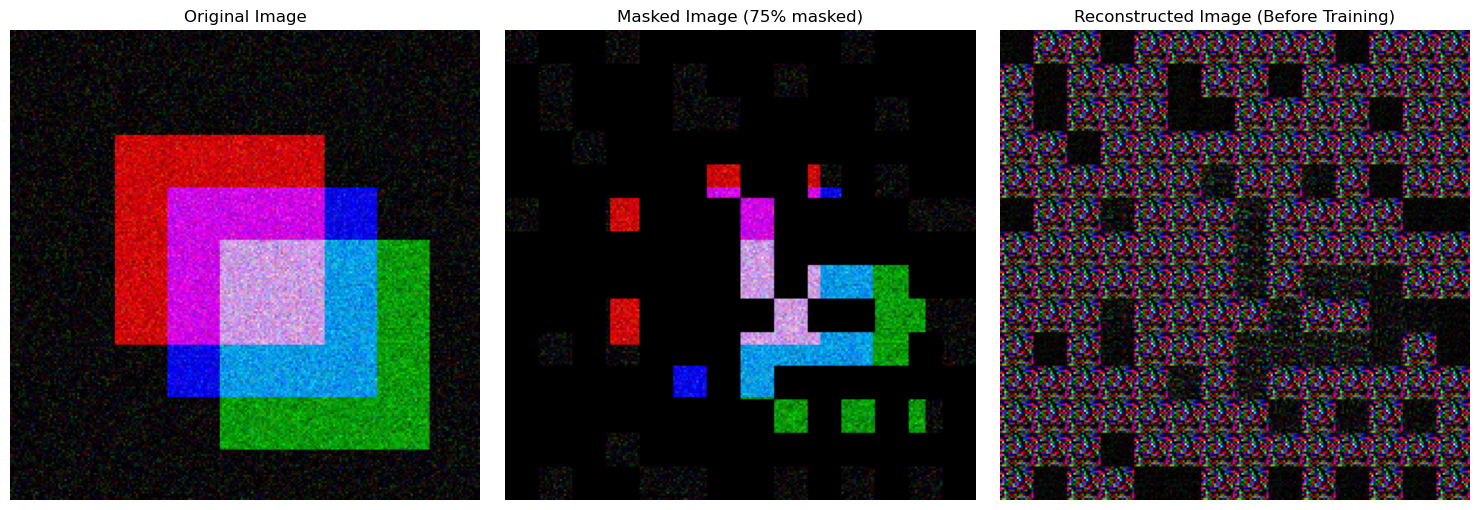

Step 5: Visualized original, masked, and reconstructed images. Reconstruction is blurry now but improves with training.
Key Point: MAE trains a ViT by learning from masked images. Reconstruction is just a way to evaluate learning—its main goal is to create a strong ViT for other tasks!


In [ ]:
import torch
import matplotlib.pyplot as plt

# 1. Create a Synthetic Image (Educational: Starting Point)
def create_synthetic_image():
    image = torch.zeros(1, 3, 224, 224)  # 1 image, 3 channels (RGB), 224x224 size
    image[0, 0, 50:150, 50:150] = 0.8   # Red rectangle
    image[0, 1, 100:200, 100:200] = 0.6 # Green rectangle
    image[0, 2, 75:175, 75:175] = 0.9   # Blue rectangle
    image += torch.randn_like(image) * 0.1  # Add noise for texture
    return torch.clamp(image, 0, 1)  # Keep values between 0 and 1

image = create_synthetic_image()
print("Step 1: Created original image with colored rectangles and noise.")

# 2. Split Image into Patches (Educational: Break into Manageable Pieces)
def image_to_patches(image, patch_size=16):
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(1, -1, 3 * patch_size * patch_size)
    return patches  # Shape: [1, 196, 768]

patches = image_to_patches(image)
print("Step 2: Split image into 196 patches of 16x16 pixels each.")

# 3. Mask 75% of Patches (Educational: Challenge the Model)
def mask_patches(patches, mask_ratio=0.75):
    num_patches = patches.shape[1]
    num_unmasked = int((1 - mask_ratio) * num_patches)
    indices = torch.randperm(num_patches)[:num_unmasked]
    mask = torch.zeros(num_patches, dtype=torch.bool)
    mask[indices] = True
    unmasked_patches = patches[:, indices, :]
    return unmasked_patches, mask, indices

unmasked_patches, mask, indices = mask_patches(patches)
print("Step 3: Masked 75% of patches, leaving 25% visible to train the ViT.")

# 4. Simple Encoder and Decoder (Educational: Learning and Predicting)
class SimpleEncoder(torch.nn.Module):
    def __init__(self, patch_dim=768, hidden_dim=128):
        super().__init__()
        self.linear = torch.nn.Linear(patch_dim, hidden_dim)
        self.pos_embed = torch.nn.Parameter(torch.randn(1, 196, hidden_dim) * 0.02)

    def forward(self, patches, indices):
        embedded = self.linear(patches)
        pos = self.pos_embed[:, indices, :]
        return embedded + pos

class SimpleDecoder(torch.nn.Module):
    def __init__(self, hidden_dim=128, patch_dim=768):
        super().__init__()
        self.linear = torch.nn.Linear(hidden_dim, patch_dim)
        self.mask_token = torch.nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.pos_embed = torch.nn.Parameter(torch.randn(1, 196, hidden_dim) * 0.02)

    def forward(self, encoded, mask, indices, num_patches):
        full_sequence = self.mask_token.expand(1, num_patches, -1).clone()
        full_sequence[:, indices, :] = encoded
        full_sequence = full_sequence + self.pos_embed
        return self.linear(full_sequence)

encoder = SimpleEncoder()
decoder = SimpleDecoder()
encoded_patches = encoder(unmasked_patches, indices)
reconstructed_patches = decoder(encoded_patches, mask, indices, patches.shape[1])
print("Step 4: Encoder processes visible patches, decoder predicts all patches (poor quality without training).")

# 5. Visualize the Process (Educational: See the Result)
def patches_to_image(patches, image_size=224, patch_size=16):
    patches_per_side = image_size // patch_size
    patches = patches.reshape(1, patches_per_side, patches_per_side, 3, patch_size, patch_size)
    patches = patches.permute(0, 3, 1, 4, 2, 5)
    return patches.reshape(1, 3, image_size, image_size)

masked_image = patches.clone()
masked_image[:, ~mask, :] = 0  # Masked areas become black
masked_image = patches_to_image(masked_image)
reconstructed_image = patches_to_image(reconstructed_patches.detach())

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title("Original Image"); plt.imshow(image[0].permute(1, 2, 0).clamp(0, 1)); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Masked Image (75% masked)"); plt.imshow(masked_image[0].permute(1, 2, 0).clamp(0, 1)); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("Reconstructed Image (Before Training)"); plt.imshow(reconstructed_image[0].permute(1, 2, 0).clamp(0, 1)); plt.axis('off')
plt.tight_layout()
plt.show()
print("Step 5: Visualized original, masked, and reconstructed images. Reconstruction is blurry now but improves with training.")

# 6. Key Takeaway
print("Key Point: MAE trains a ViT by learning from masked images. Reconstruction is just a way to evaluate learning—its main goal is to create a strong ViT for other tasks!")